In [1]:
import cv2, time
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

# Load images

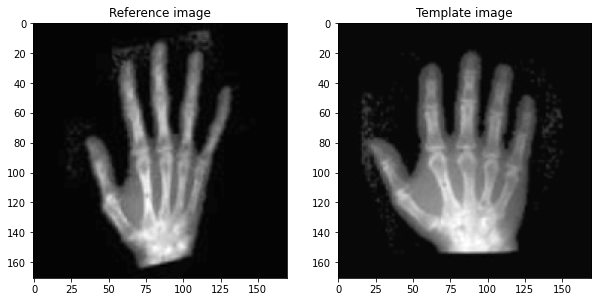

In [2]:
ref_img = cv2.imread('./Images/R1.png',32)
temp_img = cv2.imread('./Images/T1.png',32)
'''img_shape = (128,128)
height,width = img_shape[0], img_shape[1]
center = (height//2,width//2)
ref_img = cv2.circle(np.zeros(img_shape),center,img_shape[0]*3//20,255,-1)
temp_img = cv2.ellipse(np.zeros(img_shape),center,(img_shape[0]*3//20,img_shape[0]//10),0,0,360,255,-1)'''

figure = plt.figure(figsize=(10,5))
figure.add_subplot(1,2,1)
plt.title('Reference image')
plt.imshow(ref_img,cmap='gray',vmax=255,vmin=0)
figure.add_subplot(1,2,2)
plt.title('Template image')
plt.imshow(temp_img,cmap='gray',vmax=255,vmin=0)
plt.show()

# Normalize images

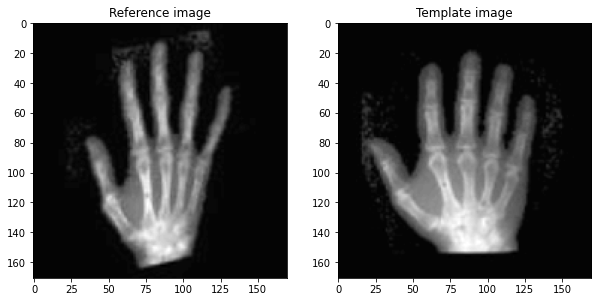

In [3]:
img_shape = (min(ref_img.shape[0],temp_img.shape[0]),min(ref_img.shape[1],temp_img.shape[1]))
ref_img = ref_img[:img_shape[0],:img_shape[1]]
temp_img = temp_img[:img_shape[0],:img_shape[1]]

# from 0-255 to 0-1 in Tensor type
ref_img = np.float32((ref_img-np.min(ref_img))/(np.max(ref_img)-np.min(ref_img)))
temp_img = np.float32((temp_img-np.min(temp_img))/(np.max(temp_img)-np.min(temp_img)))

figure = plt.figure(figsize=(10,5))
figure.add_subplot(1,2,1)
plt.title('Reference image')
plt.imshow(ref_img,cmap='gray')
figure.add_subplot(1,2,2)
plt.title('Template image')
plt.imshow(temp_img,cmap='gray')
plt.show()

# Setup functions

In [4]:
# Dense image warp from Tensorflow addons
# There is an error using tfa.image.dense_image_warp
# define same tfa.image.dense_image_warp

from tensorflow_addons.utils import types
from typing import Optional

def _get_dim(x, idx):
    if x.shape.ndims is None:
        return tf.shape(x)[idx]
    return x.shape[idx] or tf.shape(x)[idx]

def dense_image_warp(
    image: types.TensorLike, flow: types.TensorLike, name: Optional[str] = None
) -> tf.Tensor:
    with tf.name_scope(name or "dense_image_warp"):
        image = tf.convert_to_tensor(image)
        flow = tf.convert_to_tensor(flow)
        batch_size, height, width, channels = (
            _get_dim(image, 0),
            _get_dim(image, 1),
            _get_dim(image, 2),
            _get_dim(image, 3),
        )

        # The flow is defined on the image grid. Turn the flow into a list of query
        # points in the grid space.
        grid_x, grid_y = tf.meshgrid(tf.range(width), tf.range(height))
        stacked_grid = tf.cast(tf.stack([grid_y, grid_x], axis=2), flow.dtype)
        batched_grid = tf.expand_dims(stacked_grid, axis=0)
        query_points_on_grid = batched_grid - flow
        query_points_flattened = tf.reshape(
            query_points_on_grid, [batch_size, height * width, 2]
        )
        # Compute values at the query points, then reshape the result back to the
        # image grid.
        interpolated = tfa.image.interpolate_bilinear(image, query_points_flattened)
        interpolated = tf.reshape(interpolated, [batch_size, height, width, channels])
        return interpolated

In [5]:
def img_grad(img):
    # Image gradient by central difference
    dx = tf.pad((img[2:,:]-img[:-2,:])/2,paddings=([[1,1],[0,0]]))
    dy = tf.pad((img[:,2:]-img[:,:-2])/2,paddings=([[0,0],[1,1]]))
    return tf.stack([dx, dy], axis=0)

def exp_vec_field(vec_field,update_step_length):
    small_vec = 1*vec_field
    max_length_vec = tf.reduce_max(tf.norm(small_vec,axis=0))
    N = 0
    while max_length_vec>update_step_length:
        small_vec /= 2
        max_length_vec = tf.reduce_max(tf.norm(small_vec,axis=0))
        N+=1
    flow = tf.expand_dims(tf.transpose(small_vec,[1,2,0]),axis=0) #(1,img_shape[0],img_shape[1],2)
    for _ in range(N):
        flow += dense_image_warp(flow,-flow) #(1,img_shape[0],img_shape[1],2)
    return tf.transpose(flow[0],[2,0,1])
    

# Setup parameter

In [6]:
fluid_sigma = 1
diffusion_sigma = 1
update_step_length = 0.5
print_every = 100
beta = 1e-6

#stop
Imax = 1000
rel_ssd_eps = 5e-2
rel_diff_eps = 1e-3

# Diffeomorphic demons

In [7]:
start_time = time.time()
displacement_field = np.zeros((img_shape[0],img_shape[1],2)) #initial of (shape img_shape[0],img_shape[1],2)
expand_dim_temp_img = tf.expand_dims(tf.expand_dims(temp_img,0),-1) # shape (batch=1,img_shape[0],img_shape[1],channel=1)
warped_img = tf.squeeze(dense_image_warp(expand_dim_temp_img,tf.expand_dims(displacement_field,0)))
diff_intensity = tf.subtract(ref_img,warped_img)
ssd0 = tf.norm(diff_intensity)/2
rel_ssds = tf.constant([1.])
t_loop = time.time()
for i in range(Imax):
    displacement_field_old = 1*displacement_field
    # compute the update fields
    J = img_grad(warped_img) #moving demon force of shape (2,img_shape[0],img_shape[1])
    update_fields = -((diff_intensity*J)/(tf.norm(J,axis=0)**2+diff_intensity**2+beta)) #shape (2,img_shape[0],img_shape[1])
    # fluid-like regularization
    update_field_x = tfa.image.gaussian_filter2d(update_fields[0],padding="SYMMETRIC",sigma=fluid_sigma)
    update_field_y = tfa.image.gaussian_filter2d(update_fields[1],padding="SYMMETRIC",sigma=fluid_sigma)
    update_fields = tf.stack([update_field_x,update_field_y],0) #shape (2,img_shape[0],img_shape[1])
    # update the correspondence fields by diffeomorphic type
    exp_update_fields = exp_vec_field(update_fields,update_step_length) #(2,img_shape[0],img_shape[1])
    dis_warp = dense_image_warp(tf.expand_dims(displacement_field,0),-tf.expand_dims(tf.transpose(exp_update_fields,[1,2,0]),0)) #(1,img_shape[0],img_shape[1],2)
    dis_warp = tf.cast(dis_warp,tf.float32)
    corres_fields = tf.math.add(exp_update_fields,tf.transpose(dis_warp[0],[2,0,1])) #(2,img_shape[0],img_shape[1])
    # diffusion-like regularization
    corres_field_x = tfa.image.gaussian_filter2d(corres_fields[0],padding="SYMMETRIC",sigma=diffusion_sigma)
    corres_field_y = tfa.image.gaussian_filter2d(corres_fields[1],padding="SYMMETRIC",sigma=diffusion_sigma)
    displacement_field = tf.stack([corres_field_x,corres_field_y],-1) #shape (img_shape[0],img_shape[1],2)
    
    warped_img = tf.squeeze(dense_image_warp(expand_dim_temp_img,tf.expand_dims(displacement_field,0)))
    diff_intensity = tf.subtract(ref_img,warped_img)
    
    rel_diff_disp_field = tf.norm(displacement_field-displacement_field_old)/tf.norm(displacement_field)
    
    ssd = tf.norm(diff_intensity)/2
    rel_ssd = ssd/ssd0
    rel_ssds = tf.concat([rel_ssds,[rel_ssd]],axis=0)
    
    if (i+1)%print_every==0:
        print(i+1)
        print('\t',print_every,'rounds take time =',time.time()-t_loop)
        t_loop = time.time()
        print('\trelative different displacement field  = ',rel_diff_disp_field.numpy())
        print('\trelative ssd = ',rel_ssd.numpy())
    if rel_diff_disp_field<rel_diff_eps:
        print('displacement field dose not change')
        break
    if rel_ssd<rel_ssd_eps:
        print('converges by relative ssd')
        break

if i==Imax-1:
    print('Exceed iterations')
print('total time',time.time()-start_time)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
100
	 100 rounds take time = 3.960216999053955
	relative different displacement field  =  0.0140232695
	relative ssd =  0.48246238
200
	 100 rounds take time = 1.2312748432159424
	relative different displacement field  =  0.010103306
	relative ssd =  0.35341212
300
	 100 rounds take time = 1.222712516784668
	relative different displacement field  =  0.009388106
	relative ssd =  0.28238934
400
	 100 rounds take time = 1.2603368759155273
	relative different displacement field  =  0.008671873
	relative ssd =  0.23981589
500
	 100 rounds take time = 1.2013754844665527
	relative different displacement field  =  0.007941898
	relative ssd =  0.22316323
600
	 100 rounds take time = 1.2490746974945068
	relative different displacement field  =  0.0072052367
	relative ssd =  0.21834093
700
	 100 rounds take time = 1.2944505214691162
	relative different displace

# display result

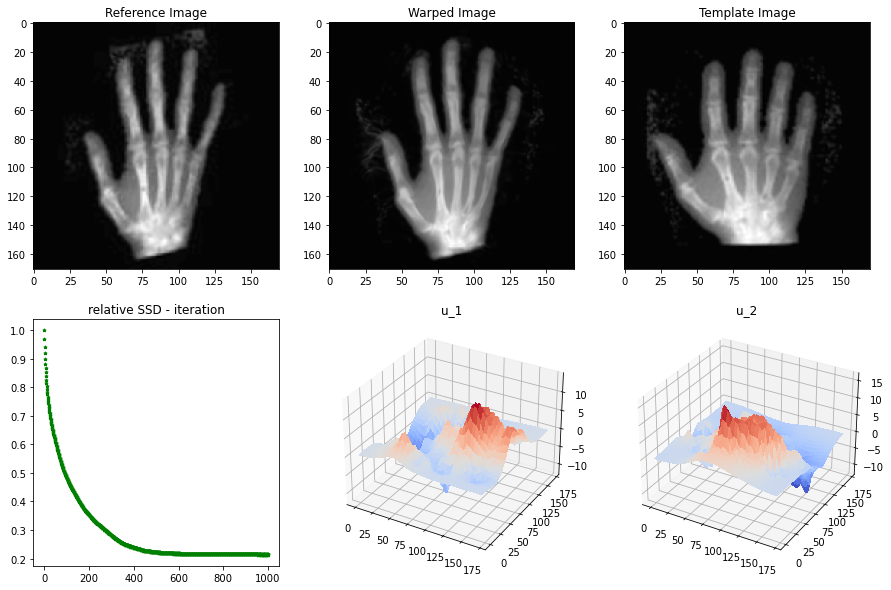

In [9]:
from matplotlib import cm
X = np.arange(0,img_shape[1],1)
Y = np.arange(0,img_shape[0],1)
Y, X = np.meshgrid(X, Y)
fig = plt.figure(figsize=(15,10))
fig.add_subplot(2,3,1)
plt.title('Reference Image')
plt.imshow(ref_img,cmap='gray')
fig.add_subplot(2,3,2)
plt.title('Warped Image')
plt.imshow(warped_img,cmap='gray')
fig.add_subplot(2,3,3)
plt.title('Template Image')
plt.imshow(temp_img,cmap='gray')
fig.add_subplot(2,3,4)
plt.title('relative SSD - iteration')
plt.scatter(np.arange(i+2),rel_ssds,color="green",marker="*",s=10)
u_1 = fig.add_subplot(235,projection='3d')
plt.title('u_1')
u_1.plot_surface(X, Y, displacement_field[:,:,0], cmap=cm.coolwarm,linewidth=0, antialiased=False)
u_2 = fig.add_subplot(236,projection='3d')
plt.title('u_2')
u_2.plot_surface(X, Y, displacement_field[:,:,1], cmap=cm.coolwarm,linewidth=0, antialiased=False)
plt.show()

## Vector Field (90 degree counterclockwise rotation)

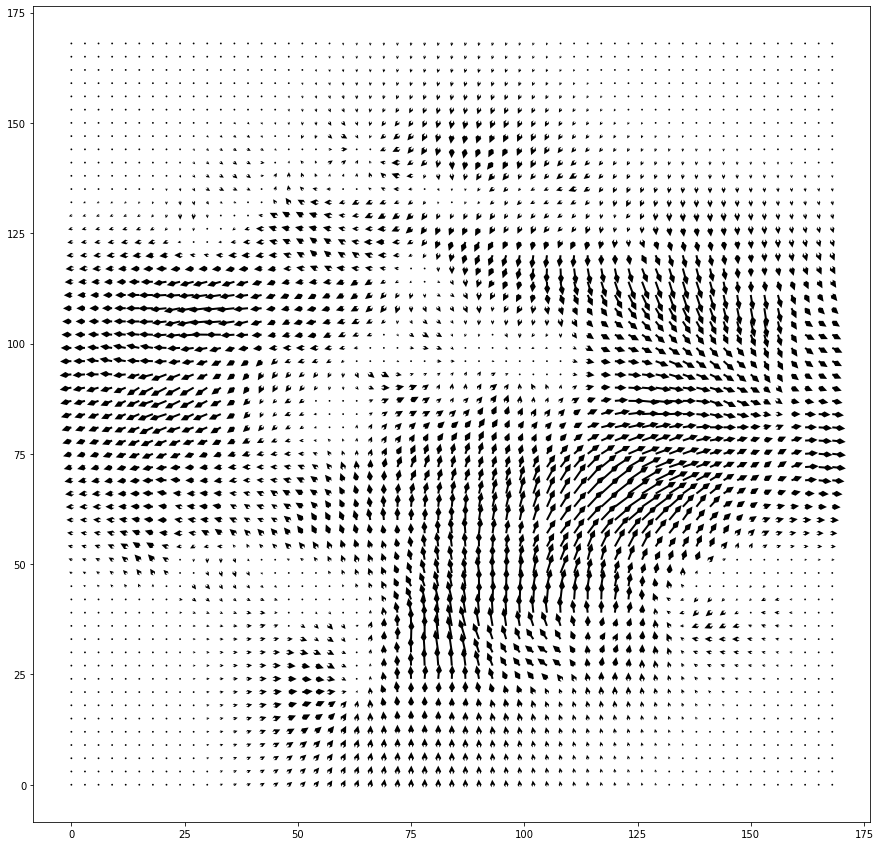

In [13]:
n = 3
fig = plt.figure(figsize=(15,15))
plt.quiver(X[::n,::n],Y[::n,::n],displacement_field[::n,::n,0],displacement_field[::n,::n,1],units='xy',scale=6-n
           ,headlength=3)
plt.show()